# <center>Прогнозирование результатов футбольных матчей</center>
<center> Автор: Разумов Илья

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import StratifiedKFold
from sklearn.cross_validation import train_test_split
from sklearn.learning_curve import validation_curve
from sklearn.learning_curve import learning_curve
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')


#### Запишем данные в переменную df

In [4]:
df = pd.read_csv('football.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16456 entries, 0 to 16455
Data columns (total 18 columns):
tour                      16456 non-null int64
team_home                 16456 non-null object
team_away                 16456 non-null object
time                      16456 non-null object
champ                     16456 non-null object
team_home_substitution    3911 non-null object
team_home_reserved        1781 non-null object
team_home_yellow_cards    3269 non-null object
team_home_squad           4003 non-null object
team_home_red_cards       406 non-null object
team_away_substitution    3907 non-null object
team_away_reserved        1796 non-null object
team_away_yellow_cards    3480 non-null object
team_away_squad           4002 non-null object
team_away_red_cards       553 non-null object
team_home_score           16456 non-null int64
team_away_score           16456 non-null int64
target                    16456 non-null int64
dtypes: int64(4), object(14)
memory usage: 

## Описание данных
Каждая строка - один матч двух футбольных команд
<br>Каждый столбец - определенная информация о матче

<b>Описание признаков:</b>
    
<b> tour </b> - номер тура данного чемпионата <br>
<b>team_home </b> - команда, которая играет дома<br>
<b>team_away</b> - команда, которая играет в гостях <br>
<b>time</b> - дата матча<br>
<b>champ</b> - номер чемпионата <br>
<b>team_home_substitution</b> - замены домашней команды <br>
<b>team_away_substitution</b> - замены гостевой команды <br>
<b>team_home_squad</b> - cостав домашней команды <br>
<b>team_away_squad</b> - cостав гостевой команды <br>
<b>team_home_reserved</b> - резерв домашней команды <br>
<b>team_away_resreved</b> - резерв гостевой команды <br>
<b>team_home_yellow_cards</b> - кто из игроков домашней команды получил желтые карты <br>
<b>team_away_yellow_cards</b> - кто из игроков гостевой команды получил желтые карты <br>
<b>team_home_red_cards</b> - кто из игроков домашней команды получил крысные карты <br>
<b>team_away_red_cards</b> - кто из игроков гостевой команды получил красные карты <br>
<b>team_home_score</b> - количество голов, забитых хозяевами <br>
<b>team_away_score</b> - количество голов, забитых гостями <br>

<b>target </b> - целевая переменная, принимает значения 0, 1 или 2 -  ничья, победа или поражение домашней команды  <br>



<p> <i>  Если внимательно посмотреть на данные, то можно заметить что многие признаки можно узнать только после окончания матча, например: количество голов,  произведенные заменны, полученные карточки. Соответсвенно можно сделать вывод, что их нельзя использовать в построение модели. В таком случае очень много информации идет на выброс, поэтому я решил использовать эти признаки для создания новых, с помощью сбора статистики
<p> 
    


## Обработка данных создание нового DataFrame

Для сбора статистики отсортируем данные по времени

In [5]:
df['time'] =pd.to_datetime(df.time)
df = df.sort_values(by='time')

<p> Данные остортированны по времени, теперь переходим к обработке:
<p>  1. Представим в численном виде команды и чемпионаты. Для этого  просто удалим "приставки" 'team' и champ'
<p>  2. Состав команды отметим как известен или нет, состав не несет никакой информативной нагрузки, по моему мнению, т.к состав чаще неизвестен, чем известен.</b></p>
<p>  True 12545 значения NAN 
<p> False 3911
Name: team_home_substitution, dtype: int64
<p>  3. Замены представим в виде: сколько в среднем делает замен команда, до данного матча. Также карточки и забитые голы;

Создадим функции для предобработки данных

In [6]:
#номер команды
def numberForT(x):
    return int(x[4:])
#номер чемпионата
def numberForCh(x):
    return int(x[5:])
#для состава
def  player(i):
    if i == 0:
        pass
    else:
        i = 1;
    return i
# для замен  и карточек
def subs (i):
    if i==0:
        pass
    else:
        i = len(i.split(', '))   
    return i
# для обработки статистики и создания нового dataFrame
def func(teams):
    goals = []
    for i in teams:
        for j in range(len(df[df['team_home'] == i]['team_home_score'])):
            t2 = df[df['team_home'] == i]['team_away'].iloc[j]
            time = df[df['team_home'] == i]['time'].iloc[j]
            Champ =  df[df['team_home'] == i]['champ'].iloc[j]
            target = df[df['team_home'] == i]['target'].iloc[j]
            if j == 0:
                goals.append([i,
                              t2,
                              Champ,
                              np.mean(df[df['team_home'] == i]['team_home_substitution'].iloc[j]),
                              df[df['team_home'] == i]['team_home_reserved'].iloc[j],
                              df[df['team_home'] == i][ 'team_home_squad'].iloc[j],
                              np.mean(df[(df['team_away'] == t2) & (df['time'] <= time)]['team_away_substitution']),
                              df[df['team_home'] == i]['team_away_reserved'].iloc[j],
                              df[df['team_home'] == i]['team_away_squad'].iloc[j],
                              np.mean(df[df['team_home'] == i]['team_home_score'].iloc[j]),
                              np.mean(df[df['team_home'] == i]['team_away_score'].iloc[j]),
                              np.mean(df[df['team_home'] == i]['team_home_yellow_cards'].iloc[j]), 
                              np.mean(df[df['team_home'] == i]['team_home_red_cards'].iloc[j]),
                              np.mean(df[(df['team_away'] == t2) & (df['time'] <= time)]['team_away_score']),
                              np.mean(df[(df['team_away'] == t2) & (df['time'] <= time)]['team_home_score']),
                              np.mean(df[(df['team_away'] == t2) & (df['time'] <= time)]['team_away_yellow_cards']),
                              np.mean(df[(df['team_away'] == t2) & (df['time'] <=time)]['team_away_red_cards']),
                              np.sum(df[(df['team_home'] == i)& (df['target'] == 1)]['target']),
                              np.sum(df[(df['team_away'] == t2)& (df['target'] == 2)&  (df['time'] <=time)]['target'])/len(df[(df['team_away'] == t2)&   (df['time'] <=time)]),
                              np.sum(df[(df['team_home'] == i)& (df['target'] == 2)]['target']),
                              np.sum(df[(df['team_away'] == t2)& (df['target'] == 1)&  (df['time'] <=time)]['target'])/len(df[(df['team_away'] == t2) &  (df['time'] <=time)]),
                              np.sum(df[(df['team_home'] == i)& (df['target'] == 0)]['target']),
                              np.sum(df[(df['team_away'] == t2)& (df['target'] == 0)&  (df['time'] <=time)]['target'])/len(df[(df['team_away'] == t2) &  (df['time'] <=time)]),
                            target
                             ])
            else:
                goals.append([i,
                              t2,
                              Champ,
                              np.mean(df[df['team_home'] == i]['team_home_substitution'].iloc[:j]),
                              df[df['team_home'] == i]['team_home_reserved'].iloc[j],
                              df[df['team_home'] == i][ 'team_home_squad'].iloc[j],
                              np.mean(df[(df['team_away'] == t2) & (df['time'] <= time)]['team_away_substitution']),
                              df[df['team_home'] == i]['team_away_reserved'].iloc[j],
                              df[df['team_home'] == i]['team_away_squad'].iloc[j],
                              np.mean(df[df['team_home'] == i]['team_home_score'].iloc[:j]),
                              np.mean(df[df['team_home'] == i]['team_away_score'].iloc[:j]),
                              np.mean(df[df['team_home'] == i]['team_home_yellow_cards'].iloc[:j]),
                              np.mean(df[df['team_home'] == i]['team_home_red_cards'].iloc[:j]),
                              np.mean(df[(df['team_away'] == t2) & (df['time'] <= time)]['team_away_score']),
                              np.mean(df[(df['team_away'] == t2) & (df['time'] <= time)]['team_home_score']),
                              np.mean(df[(df['team_away'] == t2) & (df['time'] <= time)]['team_away_yellow_cards']),
                              np.mean(df[(df['team_away'] == t2) & (df['time'] <= time)]['team_away_red_cards']),
                              np.sum(df[(df['team_home'] == i)& (df['target'] == 1)]['target'].iloc[:j])/j,
                              np.sum(df[(df['team_away'] == t2)& (df['target'] == 2)&  (df['time'] <=time)]['target'])/len(df[(df['team_away'] == t2) &  (df['time'] <=time)]),
                              np.sum(df[(df['team_home'] == i)& (df['target'] == 2)]['target'].iloc[:j])/j,
                              np.sum(df[(df['team_away'] == t2)& (df['target'] == 1)&  (df['time'] <=time)]['target'])/len(df[(df['team_away'] == t2) &  (df['time'] <=time)]),
                              np.sum(df[(df['team_home'] == i)& (df['target'] == 0)]['target'].iloc[:j])/j,
                              np.sum(df[(df['team_away'] == t2)& (df['target'] == 0)&  (df['time'] <=time)]['target'])/len(df[(df['team_away'] == t2) &  (df['time'] <=time)]),

                              target
                             ])
                         
    return goals


Применим функции к данным и создадим DataFrame

In [7]:

T = ['team_home', 'team_away']
S = ['team_home_substitution', 'team_away_substitution','team_home_yellow_cards','team_away_yellow_cards',
    'team_home_red_cards','team_away_red_cards']
for  i in T:
    df[i] = df[i].apply(numberForT)
df[S] = df[S].fillna(0)
for i in S:
    df[i] = df[i].apply(subs)
df['champ'] = df['champ'].apply(numberForCh)
Col =[ 'team_home_reserved', 'team_home_squad', 'team_away_reserved', 'team_away_squad']
df[Col] = df[Col].fillna(0)
for i in Col:
    df[i] = df[i].apply(player)

In [8]:
df

,tour,team_home,team_away,time,champ,team_home_substitution,team_home_reserved,team_home_yellow_cards,team_home_squad,team_home_red_cards,team_away_substitution,team_away_reserved,team_away_yellow_cards,team_away_squad,team_away_red_cards,team_home_score,team_away_score,target
2155,1,89,341,2009-08-07,4,2,1,0,1,0,3,1,0,1,0,2,0,1
9199,1,330,38,2009-08-08,4,3,1,0,1,0,3,1,1,1,0,1,1,0
15692,1,75,6,2009-08-08,4,3,1,2,1,0,2,1,2,1,0,2,3,2
9950,1,167,179,2009-08-08,3,0,0,0,0,0,0,0,0,0,0,2,2,0
11398,1,202,227,2009-08-08,3,0,0,0,0,0,0,0,0,0,0,1,1,0
11448,1,215,336,2009-08-08,4,3,1,2,1,0,3,1,1,1,0,1,2,2
4223,1,188,40,2009-08-08,4,0,0,0,0,0,0,0,0,0,0,2,2,0
12950,1,201,307,2009-08-08,3,0,0,0,0,0,0,0,0,0,0,1,0,1
13423,1,221,283,2009-08-08,3,0,0,0,0,0,0,0,0,0,0,0,1,2
2391,1,279,211,2009-08-08,3,0,0,0,0,0,0,0,0,0,0,0,2,2


найдем все команды

In [9]:
T = ['team_home', 'team_away']
team = []
for i in T:
     team.append(df[i])
teams = np.unique(team)
teams

array([  0,   1,   2,   3,   5,   6,   7,   8,   9,  11,  12,  13,  14,
        16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,
        29,  30,  31,  32,  33,  34,  36,  37,  38,  39,  40,  41,  42,
        43,  44,  45,  46,  48,  49,  50,  51,  52,  53,  54,  55,  56,
        57,  58,  59,  60,  61,  62,  64,  65,  66,  67,  68,  69,  70,
        71,  72,  73,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,
        85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
        98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 110, 111,
       112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 125,
       126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138,
       139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151,
       152, 154, 156, 157, 158, 159, 160, 161, 163, 164, 165, 166, 167,
       168, 169, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181,
       182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 19

Создадим новый DataFrame

In [10]:
df1 = func(teams)
data = pd.DataFrame(df1, columns=['team_home', 
                                    'team_away','champ',  'team_home_substitution', 'team_home_reserved', 
                                    'team_home_squad', 'team_away_substitution', 'team_away_reserved', 
                                    'team_away_squad', 'team_home_score_mean', 'team_score_home_missed_mean',
                                    'team_home_yellow_cards', 'team_home_red_cards', 'team_away_score_mean',
                                     'team_away_missed_score_mean','team_away_yellow_cards',
                                    'team_away_red_cards','%_WIN_HOME', '%_WIN_AWAY','%_lose_HOME', '%_lose_AWAY','%_Nich_HOME', '%_nich_AWAY', 'target'
                                   ])

Посмотрим на данные

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16456 entries, 0 to 16455
Data columns (total 24 columns):
team_home                      16456 non-null int64
team_away                      16456 non-null int64
champ                          16456 non-null int64
team_home_substitution         16456 non-null float64
team_home_reserved             16456 non-null int64
team_home_squad                16456 non-null int64
team_away_substitution         16456 non-null float64
team_away_reserved             16456 non-null int64
team_away_squad                16456 non-null int64
team_home_score_mean           16456 non-null float64
team_score_home_missed_mean    16456 non-null float64
team_home_yellow_cards         16456 non-null float64
team_home_red_cards            16456 non-null float64
team_away_score_mean           16456 non-null float64
team_away_missed_score_mean    16456 non-null float64
team_away_yellow_cards         16456 non-null float64
team_away_red_cards            16456 non-

## Описание данных
Каждая строка - один матч двух футбольных команд
<br>Каждый столбец - определенная информация о матче

<b>Описание признаков:</b>
    

<b>team_home </b> - команда, которая играет дома<br>
<b>team_away</b> - команда, которая играет в гостях <br>
<b>champ</b> - номер чемпионата <br>
<b>team_home_substitution</b> -Сколько в среденем делает замен домашняя команда <br>
<b>team_away_substitution</b> - Сколько в среденем делает замен гостевая команда <br>
<b>team_home_squad</b> - известен ли состав домашней команды <br>
<b>team_away_squad</b> - известен ли cостав гостевой команды <br>
<b>team_home_reserved</b> -известен ли  резерв домашней команды <br>
<b>team_away_resreved</b> - известен ли резерв гостевой команды <br>
<b>team_home_yellow_cards</b> - сколько в среднем команда хозяев получает желтых карт <br>
<b>team_away_yellow_cards</b> - сколько в среднем команда гостей получает желтых карт <br>
<b>team_home_red_cards</b> - сколько в среднем команда хозяев получает красных карт <br>
<b>team_away_red_cards</b> - сколько в среднем команда гостей получает красных карт <br>
<b>team_home_score_mean</b> - сколько в среднем команда хозев забивает в домашних матчах <br>
<b>team_away_score_mean</b> - сколько в среднем команда гостей забивает в гостевых матчах <br>
<b>team_home_missed_score_mean</b> - сколько в среднем команда хозев пропускает в домашних матчах <br>
<b>team_away_missed_score_mean</b> - сколько в среднем команда гостей пропускает в гостевых матчах <br>
<b>target </b> - целевая переменная, принимает значения 0, 1 или 2 -  ничья, победа или поражение домашней команды  <br>



## Визуальный анализ

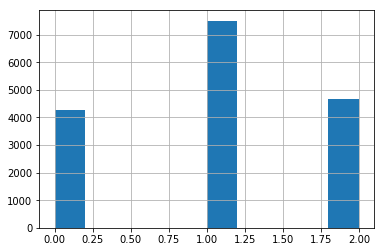

In [12]:
data['target'].hist()

Из гистограммы целевого признака видно, что целевая переменная не совсем сбалансирована.Также можно заметить, что фактор домашней команды работает

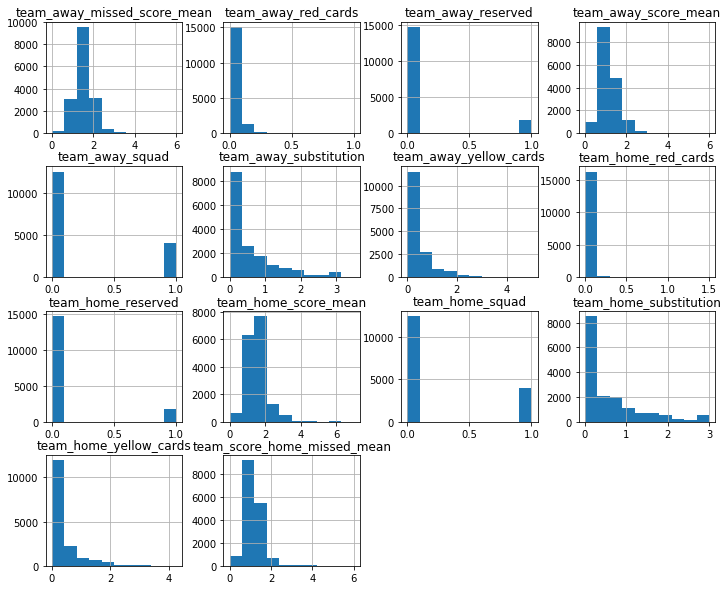

In [13]:
feat = ['team_home_substitution', 'team_home_reserved', 
        'team_home_squad', 'team_away_substitution', 'team_away_reserved', 
        'team_away_squad', 'team_home_score_mean', 'team_score_home_missed_mean',
        'team_home_yellow_cards', 'team_home_red_cards', 'team_away_score_mean',
        'team_away_missed_score_mean','team_away_yellow_cards',
        'team_away_red_cards']
plots = data[feat].hist(figsize=(12,10))

1. Команды в гостях в с реднем пропускают меньше чем забивают, с хозяевами все наоборот
2. Данные о составах очень не сбалансированы , поэтому от них можно избавится


In [14]:
data = data.drop(['team_home_reserved',
'team_home_squad',
'team_away_reserved',
'team_away_squad'],axis = 1)

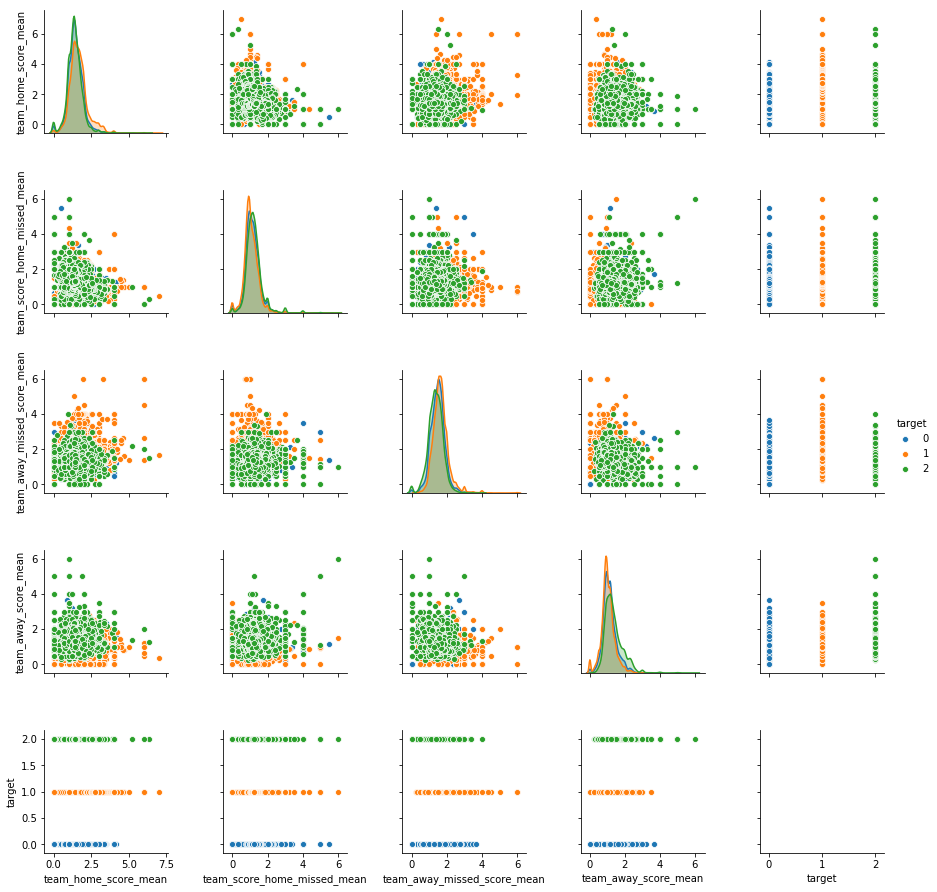

In [15]:
sns.pairplot(data[['team_home_score_mean', 'team_score_home_missed_mean','team_away_missed_score_mean', 
                 'team_away_score_mean',
                 'target']], hue='target')

На графиках все зависимости вполне ожидаемые, чем больше команды забивают,тем больше вероятность победы или ничьей, буду краток, все выводы очевидные больше забивай, меньше пропускай.

##  Построение модели

Разделим данные на выборки - тренировочную и тестовую 

In [50]:
X = data[['team_home','team_away', 'team_home_substitution', 'team_away_substitution', 'team_home_score_mean', 'team_score_home_missed_mean',
                                    'team_home_yellow_cards', 'team_home_red_cards', 'team_away_score_mean',
                                     'team_away_missed_score_mean','team_away_yellow_cards',
                                    'team_away_red_cards']]
y = data['target']

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [52]:
classifiers = [LogisticRegression(),
               KNeighborsClassifier(),
               GradientBoostingClassifier(), 
               RandomForestClassifier()]
 
classifiers_name = ['LogisticRegression',
                    'KNeighborsClassifier',
                    'GradientBoostingClassifier', 
                    'RandomForestClassifier',]

In [53]:
n_folds = 3
scores = []
fits = []
pred = []
logistic_params = { 'max_iter': [50,100],
                   'multi_class': ('multinomial', 'ovr'),
                   'C': (.01,.1,1,5),
                   'solver': ('newton-cg', 'lbfgs', 'sag', 'saga')}
knn_params = {'n_neighbors': list(range(5, 20, 2)),
             'weights': ('uniform', 'distance') }
gbm_params = {'n_estimators': [100, 200, 300],
              'learning_rate':(0.1, 0.5, 1),
              'max_depth': list(range(2, 6)), 
              'min_samples_leaf': list(range(10, 31, 10))}
forest_params = {'n_estimators': [100, 200, 300],
                 'criterion': ('gini', 'entropy'), 
                 'max_depth': list(range(2, 6)), 
                 'min_samples_leaf': list(range(10, 31, 10))}

params = [logistic_params, knn_params, gbm_params, forest_params]

In [54]:
%time
for i, each_classifier in enumerate(classifiers):
    clf = each_classifier
    clf_params = params[i]
    grid = GridSearchCV(clf, clf_params, n_jobs = 4,
                        cv=StratifiedKFold(y_train, n_folds=n_folds,
                        shuffle=False, random_state=42), 
                         scoring="accuracy")
    grid.fit(X_train, y_train)
    fits.append(grid.best_params_)
    clf_best_score = grid.best_score_
    pred.append(grid.predict(X_train))
    scores.append(clf_best_score)
    print(classifiers_name[i], clf_best_score, "\n", grid.best_params_, "\n")

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 4.29 µs
LogisticRegression 0.5321642503689556 
 {'C': 1, 'max_iter': 50, 'multi_class': 'multinomial', 'solver': 'newton-cg'} 

KNeighborsClassifier 0.4289434846774894 
 {'n_neighbors': 19, 'weights': 'distance'} 

GradientBoostingClassifier 0.5341609514714819 
 {'learning_rate': 0.1, 'max_depth': 2, 'min_samples_leaf': 30, 'n_estimators': 100} 

RandomForestClassifier 0.5273027172497613 
 {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 10, 'n_estimators': 300} 



результаты не очень хорошие, можно попробывать добавить три признака - предсказания по линейной, КНН,  Рандомному лесу и градиентному спуску, а после еще раз применить градиентный спуск.

In [55]:
k=0
for i in pred:
    X_train[str(k)] = pd.Series(i)
    k+=1


добавим новые признаки в X_train, в выборке есть значения которые не смогла предсказать модель заменимна предидущие значения

In [56]:
X_train = X_train.fillna(method = 'pad')

In [57]:
clf_params = {'n_estimators': (200, 300, 400, 500), 
              'learning_rate': (0.1, 0.3, 0.5, 0.75, 1), 
              'min_samples_leaf': list(range(1, 14, 3))}

clf = GradientBoostingClassifier()
grid = GridSearchCV(clf, clf_params, cv=n_folds, n_jobs = -1, 
                     scoring="accuracy")
grid.fit(X_train, y_train)
clf_best_score = grid.best_score_
clf_best_params = grid.best_params_
clf_best = grid.best_estimator_
mean_validation_scores = []
print("Лучший результат", clf_best_score, 
      "лучшие параметры", clf_best_params)

Лучший результат 0.5287785398038024 лучшие параметры {'learning_rate': 0.1, 'min_samples_leaf': 1, 'n_estimators': 200}


Данный метод не принес результатов, следовательно лучше использовать простой градиентный бустинг

## Проверка модели на отложенных данных

In [66]:

clf = GradientBoostingClassifier(learning_rate =  0.1, max_depth = 2, min_samples_leaf = 30, n_estimators = 100)

clf.fit(X_train, y_train)




GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=2,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=30, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [70]:
y=clf.predict(X_test)


## Вывод

In [72]:
clf.score(X_test,y_test)

0.529471338869759